# Syntactic Complexity
Adj/noun ratio, dependency tree depth, punctuation density, FK grade, function word PCA, discourse connective density.

In [ ]:
import os
import re
import math
import collections
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
import spacy
import nltk

try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    from spacy.cli import download
    download("en_core_web_sm")
    nlp = spacy.load("en_core_web_sm")

try:
    nltk.data.find('corpora/cmudict')
except LookupError:
    nltk.download('cmudict', quiet=True)

Libraries loaded & NLP models ready.


## Load Data

In [2]:
candidates = [Path.cwd(), Path.cwd().parent, Path.cwd().parent.parent]

def find_path(rel):
    for base in candidates:
        p = base.joinpath(rel)
        if p.exists():
            return p.resolve()
    return None

merged_path = find_path(Path('data').joinpath('data.parquet'))
if merged_path:
    df = pd.read_parquet(merged_path)
    print(f"Read merged data.parquet ({merged_path}) with {len(df)} rows")

    def extract_author(fc):
        if isinstance(fc, dict):
            return fc.get('author') or fc.get('persona_mimicked') or fc.get('persona')
        return None

    df['author_key'] = df['feature_cache'].apply(extract_author).fillna('Unknown')
    df['topic_key'] = df['topic'].astype(str)
    df['class_key'] = df['class']
else:
    print("No data available.")
    df = pd.DataFrame()

Read merged data.parquet (W:\Programming\PKOG\preprecogclean\data\data.parquet) with 1508 rows


## Syntactic features
Adj/noun ratio, tree depth, FK grade, discourse density via spaCy.

In [3]:
DISCOURSE_MARKERS = {
    "however", "therefore", "consequently", "furthermore", "moreover", "nevertheless",
    "thus", "hence", "accordingly", "subsequently", "conversely", "meanwhile",
    "nonetheless", "notwithstanding", "additionally", "alternatively", "undoubtedly",
    "specifically", "similarly", "finally", "indeed"
}

def get_tree_depth(token):
    if not list(token.children):
        return 1
    return 1 + max(get_tree_depth(child) for child in token.children)

def calculate_average_depth(doc):
    depths = []
    for sent in doc.sents:
        depths.append(get_tree_depth(sent.root))
    return sum(depths) / len(depths) if depths else 0

def syllable_count(word):
    word = word.lower()
    count = len(re.findall(r'[aeiouy]+', word))
    if word.endswith('e'): count -= 1
    return max(1, count)

def flesch_kincaid(doc):
    n_words = len([t for t in doc if not t.is_punct])
    n_sents = len(list(doc.sents))
    n_syllables = sum(syllable_count(t.text) for t in doc if not t.is_punct)
    if n_words == 0 or n_sents == 0: return 0
    return 0.39 * (n_words / n_sents) + 11.8 * (n_syllables / n_words) - 15.59

def analyze_syntax(text):
    if not text: return pd.Series([0, 0, 0, 0])
    doc = nlp(text)
    adjs = len([t for t in doc if t.pos_ == "ADJ"])
    nouns = len([t for t in doc if t.pos_ == "NOUN"])
    adj_noun_ratio = adjs / nouns if nouns > 0 else 0
    avg_depth = calculate_average_depth(doc)
    fk_grade = flesch_kincaid(doc)
    discourse_count = len([t for t in doc if t.lower_ in DISCOURSE_MARKERS])
    discourse_density = (discourse_count / len(doc)) * 100 if len(doc) > 0 else 0
    return pd.Series({
        "Adj/Noun Ratio": adj_noun_ratio,
        "Tree Depth": avg_depth,
        "FK Grade": fk_grade,
        "Discourse Density": discourse_density
    })

if not df.empty:
    print("Running SpaCy pipeline on all rows...")
    syntax_features = df['text'].apply(analyze_syntax)
    df = pd.concat([df, syntax_features], axis=1)
    print("Syntactic features computed.")

Running SpaCy pipeline on all rows...
Syntactic features computed.


## Punctuation density heatmap

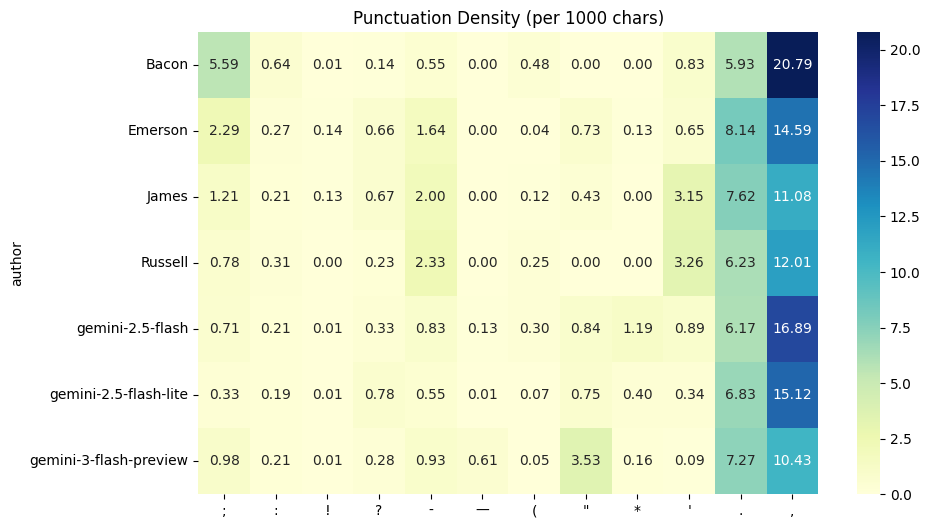

In [4]:
PUNCT_MARKS = [';', ':', '!', '?', '-', '\u2014', '(', '\"', '*', '\'', '.', ',']

def get_punct_counts(text):
    c = collections.Counter(text)
    return {p: c[p] for p in PUNCT_MARKS}

if not df.empty:
    punct_df = df['text'].apply(lambda x: pd.Series(get_punct_counts(x)))
    punct_df = punct_df.div(df['text'].str.len(), axis=0) * 1000
    punct_df['author'] = df['author_key']
    heatmap_data = punct_df.groupby('author').mean()

    plt.figure(figsize=(10, 6))
    sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", fmt=".2f")
    plt.title("Punctuation Density (per 1000 chars)")
    plt.show()

## Function word PCA
Top 50 function words projected to 2D.

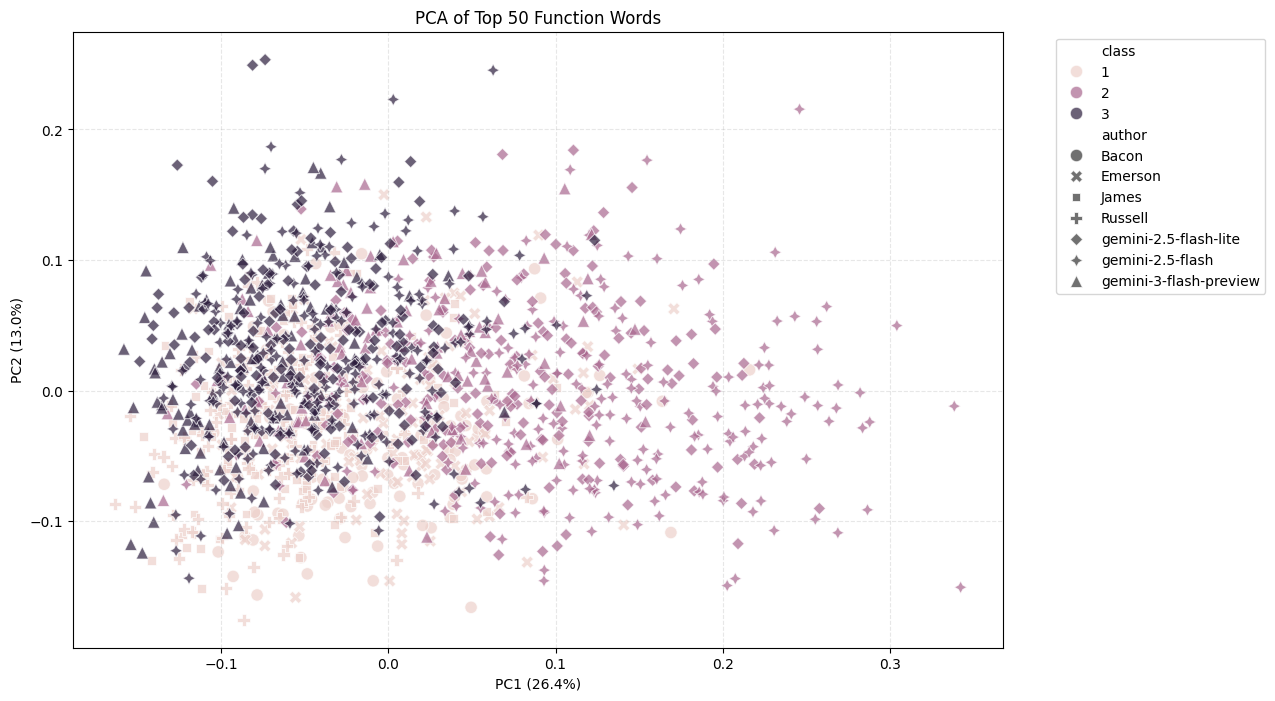

In [5]:
if not df.empty:
    vectorizer = CountVectorizer(stop_words=None, max_features=100)
    dtm = vectorizer.fit_transform(df['text'])
    all_words = vectorizer.get_feature_names_out()

    std_stops = spacy.lang.en.stop_words.STOP_WORDS
    function_indices = [i for i, w in enumerate(all_words) if w in std_stops]

    if len(function_indices) < 20:
        function_indices = range(50)
    else:
        function_indices = function_indices[:50]

    function_word_dtm = dtm[:, function_indices]
    row_sums = np.array(function_word_dtm.sum(axis=1))
    freq_matrix = function_word_dtm / row_sums

    pca = PCA(n_components=2)
    components = pca.fit_transform(freq_matrix)

    pca_df = pd.DataFrame(components, columns=['PC1', 'PC2'])
    pca_df['class'] = df['class_key']
    pca_df['author'] = df['author_key']

    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='class', style='author', alpha=0.7, s=80)
    plt.title("PCA of Top 50 Function Words")
    plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%})")
    plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%})")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.show()

## Aggregated results

In [6]:
if not df.empty:
    target_cols = ["Adj/Noun Ratio", "Tree Depth", "FK Grade", "Discourse Density"]

    print("\n### Mean Metrics by Class")
    display(df.groupby("class_key")[target_cols].mean())

    print("\n### Mean Metrics by Author")
    display(df.groupby("author_key")[target_cols].mean().sort_values("Tree Depth", ascending=False))


### Mean Metrics by Class


,Adj/Noun Ratio,Tree Depth,FK Grade,Discourse Density
class_key,,,,
1,0.417999,6.975049,12.601445,0.346306
2,0.471795,7.183053,16.112961,0.349097
3,0.457609,7.224304,13.551703,0.378327



### Mean Metrics by Author


,Adj/Noun Ratio,Tree Depth,FK Grade,Discourse Density
author_key,,,,
Russell,0.436372,7.703248,13.971202,0.711914
gemini-3-flash-preview,0.400595,7.367638,12.917967,0.261248
gemini-2.5-flash,0.486516,7.349628,16.303333,0.369429
Bacon,0.378878,7.072515,14.033503,0.233293
gemini-2.5-flash-lite,0.473708,6.924915,14.062376,0.415057
James,0.475291,6.674000,11.813116,0.325646
Emerson,0.381454,6.450436,10.587961,0.114369
